In [1]:
import pytest
import numpy as np
import setpath
from time_integrator import RK4Integrator
from nn_models import TwoParticleNNLagrangian, LagrangianModel
from initializer import TwoParticleConstantInitializer
from dynamical_system import TwoParticleSystem
from trajectories import TrajectoryGenerator, PositionMonitor, InvariantMonitor, TwoParticleInvariantMonitor
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Load models from disk and run trajectory generators

In [10]:
dt = 0.01
# final time
t_final = 8.0
dim_space = 3
dim = 2*dim_space
# Dynamical system for exact integration
dynamical_system = TwoParticleSystem(dim_space)
initializer = TwoParticleConstantInitializer(dim)
perturbed_initializer = TwoParticleConstantInitializer(dim,perturbation=0.05)

monitors = {}
monitors_nn = {}
monitors_nn_perturbed = {}

for model_label in ["","trans","rot","rot_trans"]:
    # load Lagrangian from disk
    filetag = "_" if model_label == "" else "_"+model_label+"_"
    model_filename = f"assets/trained_models/two_particle/nn_lagrangian_3d{filetag}2Aug2022/"
    nn_lagrangian = TwoParticleNNLagrangian.from_saved_model(model_filename)
    model = LagrangianModel(nn_lagrangian)
    dim_space = nn_lagrangian.dim_space
    dim = 2*dim_space

    # Monitors
    monitors[model_label] = [PositionMonitor(dim),]
    monitors_nn[model_label] = [PositionMonitor(dim),
                                InvariantMonitor(nn_lagrangian),
                                TwoParticleInvariantMonitor(dynamical_system)]
    monitors_nn_perturbed[model_label] = [PositionMonitor(dim)]

    # Run trajectory generators
    trajectory_generator = TrajectoryGenerator(dynamical_system,
                                               initializer,
                                               monitors[model_label],
                                               dt=dt,t_final=t_final)
    trajectory_generator_nn = TrajectoryGenerator(model,
                                                  initializer,
                                                  monitors_nn[model_label],
                                                  dt=dt,t_final=t_final)
    trajectory_generator_nn_perturbed = TrajectoryGenerator(model,
                                                            perturbed_initializer,
                                                            monitors_nn_perturbed[model_label],
                                                            dt=dt,t_final=t_final)
    trajectory_generator.run()
    trajectory_generator_nn.run()
    trajectory_generator_nn_perturbed.run()
    T = trajectory_generator.t

## Plot (projection of) trajectories

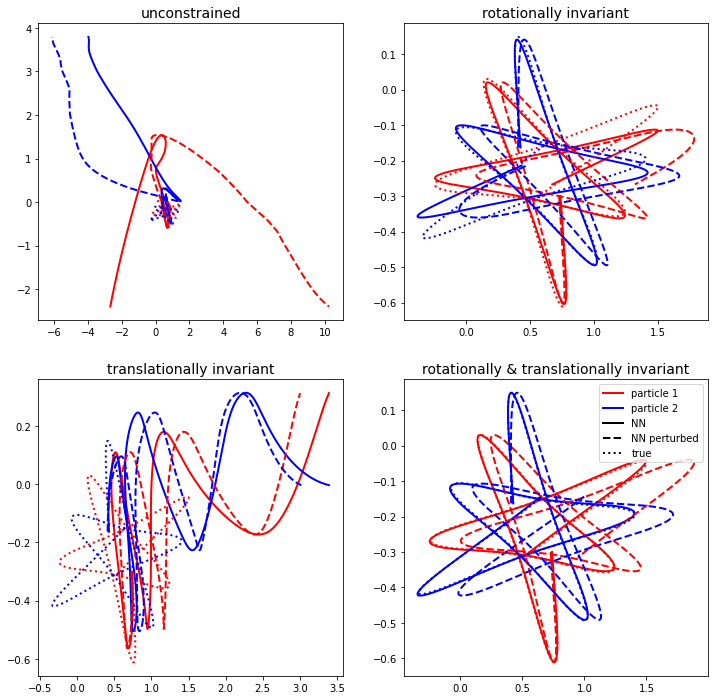

In [16]:
# Indices of space dimensions for projection
j = 0
k = 1

model_label_list = [["","rot"],["trans","rot_trans"]]

title = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

fig, axs = plt.subplots(2, 2, figsize=(12,12))
for row in [0,1]:
    for col in [0,1]:
        model_label = model_label_list[row][col]
        q_all = monitors[model_label][0].value
        q_all_nn = monitors_nn[model_label][0].value
        q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].value
        ax = axs[row,col]
        # Plot NN trajectories
        ax.plot(q_all_nn[j,:],q_all_nn[k,:],linewidth=2,label=f"particle 1",color="red")
        ax.plot(q_all_nn[dim_space+j,:],q_all_nn[dim_space+k,:],linewidth=2,label=f"particle 2",color="blue")
        ax.plot(q_all_nn_perturbed[j,:],q_all_nn[k,:],linewidth=2,linestyle="--",color="red")
        ax.plot(q_all_nn_perturbed[dim_space+j,:],q_all_nn[dim_space+k,:],linestyle="--",linewidth=2,color="blue")
        # Plot true trajectories
        ax.plot(q_all[j,:],q_all[k,:],linewidth=2,linestyle=':',color="red")
        ax.plot(q_all[dim_space+j,:],q_all[dim_space+k,:],linewidth=2,linestyle=':',color="blue")
        # Additional labels
        ax.plot([],[],linewidth=2,color='black',label="NN")
        ax.plot([],[],linewidth=2,linestyle='--',color='black',label="NN perturbed")
        ax.plot([],[],linewidth=2,linestyle=':',color='black',label="true")
        ax.set_title(title[model_label],fontsize=14)
        if row==1 and col==1:
            ax.legend(loc="upper right")
plt.show()

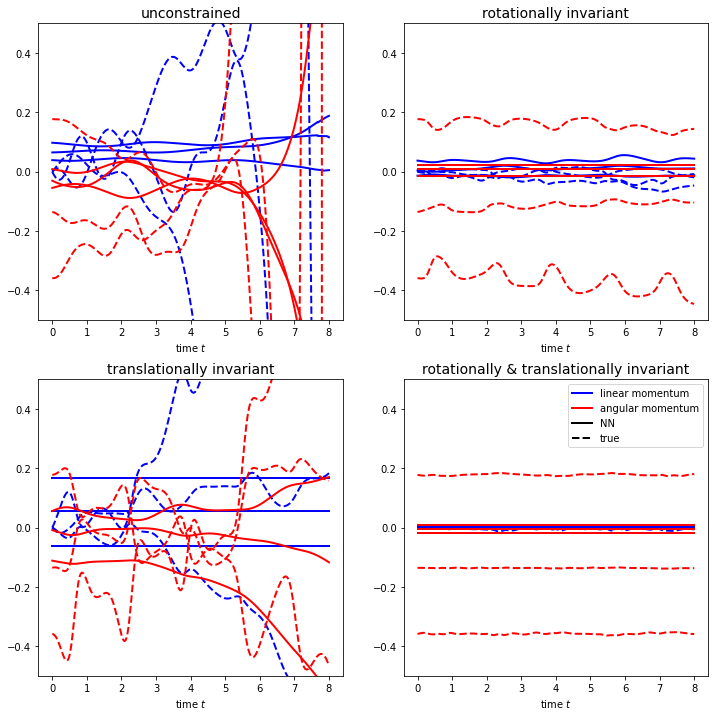

In [13]:
model_label_list = [["","rot"],["trans","rot_trans"]]

title = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

fig, axs = plt.subplots(2, 2, figsize=(12,12))
for row in [0,1]:
    for col in [0,1]:
        model_label = model_label_list[row][col]
        invariant = monitors_nn[model_label][1].value
        invariant_true = monitors_nn[model_label][2].value
        ax = axs[row,col]
        # Plot linear momentum
        for j in range(dim_space):
            ax.plot(trajectory_generator_nn.t,invariant[j],linewidth=2,color="blue")
            ax.plot(trajectory_generator_nn.t,invariant_true[j],linewidth=2,linestyle="--",color="blue")
        # Plot angular momentum
        for j in range(dim_space,dim_space*(dim_space+1)//2):
            ax.plot(trajectory_generator_nn.t,invariant[j],linewidth=2,color="red")
            ax.plot(trajectory_generator_nn.t,invariant_true[j],linewidth=2,linestyle="--",color="red")
        if row==1 and col==1:
            ax.plot([],[],linewidth=2,color="blue",label="linear momentum")
            ax.plot([],[],linewidth=2,color="red",label="angular momentum")
            ax.plot([],[],linewidth=2,color="black",label="NN")
            ax.plot([],[],linewidth=2,color="black",linestyle="--",label="true")
            ax.legend(loc="upper right")
        ax.set_xlabel("time $t$")
        ax.set_ylim(-0.5,+0.5)
        ax.set_title(title[model_label],fontsize=14)

plt.show()

## Plot deviation of NN and true trajectories

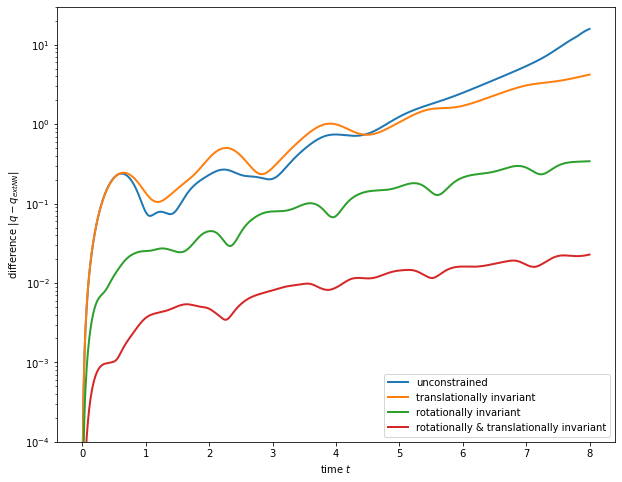

In [14]:
model_label_list = ["","trans","rot","rot_trans"]

label = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

plt.figure(figsize=(10,8))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-4,30)
for model_label in model_label_list:
    q_all = monitors[model_label][0].value
    q_all_nn = monitors_nn[model_label][0].value
    dq = np.linalg.norm(q_all_nn[:,:]-q_all[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,label=label[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel("difference $|q-q_{\text{NN}}|$")
plt.legend(loc="lower right")
plt.show()

## Plot deviation between unperturbed and perturbed trajectories

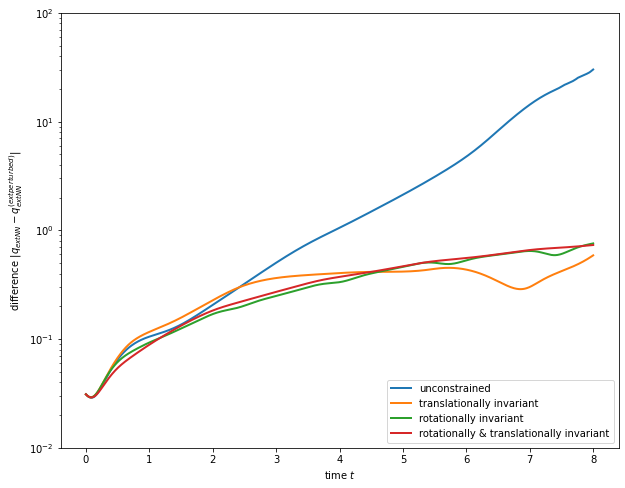

In [17]:
model_label_list = ["","trans","rot","rot_trans"]

label = {"":"unconstrained",
         "rot":"rotationally invariant",
         "trans":"translationally invariant",
         "rot_trans":"rotationally & translationally invariant",
         }

plt.figure(figsize=(10,8))
plt.gca()
ax = plt.gca()
ax.set_yscale("log")
ax.set_ylim(1.E-2,100)
for model_label in model_label_list:
    q_all_nn = monitors_nn[model_label][0].value
    q_all_nn_perturbed = monitors_nn_perturbed[model_label][0].value
    dq = np.linalg.norm(q_all_nn[:,:]-q_all_nn_perturbed[:,:],axis=0)
    plt.plot(trajectory_generator_nn.t,dq,linewidth=2,label=label[model_label])
ax.set_xlabel("time $t$")
ax.set_ylabel("difference $|q_{\text{NN}}-q^{(\text{perturbed})}_{\text{NN}}|$")
plt.legend(loc="lower right")
plt.show()